# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
from itertools import count
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='M:/programing/python/udacity/DRL_NanoDegree/p2_continuous-control/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 3. Learning Algorithm

#### DDPG

For this project I used the Deep Determenistic Policy Gradient(DDPG) algorithm to solve the environment. By using this, the agent was able to solve the environment in 136 episodes. The agent then continued to improve for another 59 episodes. The algorithm works by having the agent act in the environment and collecting rewards. These experiences are then stored in a buffer and used at a later time to train the neural networks. A neural network, called actor network is used to approximate the optimal policy from which the best believed action is selected. During training another neural network, called the critic network is used to estimate value function which is then used to evaluate the action selected by the actor network. By using these two networks in tandem, the agent is able to solve complex enviroments that contain both a continous state and action space. Since the actor network is designed to always output the best belived action, noise is added to help with exploration/exploitation. An Ornstein-Uhlenbeck process is used to generate random noise which is then scaled by a decaying epsilon value. The scaled noise is then added to the output of the actor network and finally clipped so as to keep it within the desired range.

#### Hyperparameters

<b>BUFFER_SIZE</b>........100,000......The maximum size of the replay buffer.<br>
<b>BATCH_SIZE</b>.................256......The number of samples taken from the replay buffer during traing.<br>
<b>GAMMA</b>........................0.99......The discount rate for future rewards.<br>
<b>TAU</b>.............................0.001......Used during soft_update to control how much of the local model is mixed into the target model.<br>
<b>LR_ACTOR</b>................0.001.......The Learning Rate used during training for the actor network.<br>
<b>LR_CRITIC</b>.................0.001.......The Learning Rate used during training for the critic network.<br>
<b>WEIGHT_DECAY</b>..............0.......The weight decay use for training the critic network.<br>
<b>UPDATE_EVERY</b>.............20......How many steps inbetween learning steps.<br>
<b>NUM_UPDATES</b>..............10......How many times the network is updated each learning steps.<br>
<b>EPSILON</b>........................1.0......The starting epsilon value used with an OU Noise process to help with exploration/exploitation.<br>
<b>EPSILON_DECAY</b>....0.9999......How much epsilon is decayed by after each time step.<br>

#### Model Architecture

##### Actor Network
Batch Nomalization Layer(BatchNorm1d with a size of 33 x Number of Agents)<br>
Input Layer(Fully Connected Layer with a size of 33 x Number of Agents x 128)<br>
Relu Activation<br>
Batch Nomalization Layer(BatchNorm1d with a size of 128)<br>
Hidden Layer(Fully Connected Layer with a size of 128x256)<br>
Relu Activation<br>
Batch Nomalization Layer(BatchNorm1d with a size of 256)<br>
Output Layer(Fully Connected Layer with a size of 128x4)<br>
Tanh Activation

##### Critic Network
Batch Nomalization Layer(BatchNorm1d with a size of 33 x Number of Agents)<br>
Input Layer(Fully Connected Layer with a size of 33 x Number of Agents x 128)<br>
Leaky Relu Activation<br>
Concat(Actions are added to the output of the previous layer)
Hidden Layer(Fully Connected Layer with a size of 132x256)<br>
Leaky Relu Activation<br>
Output Layer(Fully Connected Layer with a size of 256x1)

In [7]:
def ddpg(agent, max_t=1000, print_every=25):
    scores_deque = deque(maxlen=100)
    scores = []
    mov_avgs = []
    best_score = -np.inf
    best_ep = 0
    goal = 30.
    solved = False
    for i_episode in count():
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            score += rewards
            if np.any(dones):
                break
                
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        mov_avgs.append(np.mean(scores_deque))
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if mov_avgs[-1] > goal:
            if not solved:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
                solved = True
                best_score = mov_avgs[-1]
                best_ep = i_episode
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_reacher_20.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_reacher_20.pth')
                
            elif mov_avgs[-1] > best_score:
                print('Best episode so far!\
                \nEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
                best_ep = i_episode
                best_score = mov_avgs[-1]
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_reacher_20.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_reacher_20.pth')
                
            elif (i_episode - best_ep) >= 200:
                print('Training stopped. Best score not matched or exceeded for 200 episodes')
                break
                
            else:
                continue
                
    return scores, mov_avgs

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, seed=123)
scores, avgs = ddpg(agent)

Episode 0	Average Score: 0.48
Episode 25	Average Score: 1.10
Episode 50	Average Score: 3.17
Episode 75	Average Score: 10.00
Episode 100	Average Score: 16.81
Episode 125	Average Score: 26.25

Environment solved in 136 episodes!	Average Score: 30.20
Best episode so far!                
Episode 137	Average Score: 30.5405
Best episode so far!                
Episode 138	Average Score: 30.8879
Best episode so far!                
Episode 139	Average Score: 31.2269
Best episode so far!                
Episode 140	Average Score: 31.5613
Best episode so far!                
Episode 141	Average Score: 31.8874
Best episode so far!                
Episode 142	Average Score: 32.2202
Best episode so far!                
Episode 143	Average Score: 32.5424
Best episode so far!                
Episode 144	Average Score: 32.8651
Best episode so far!                
Episode 145	Average Score: 33.1783
Best episode so far!                
Episode 146	Average Score: 33.4952
Best episode so far!            

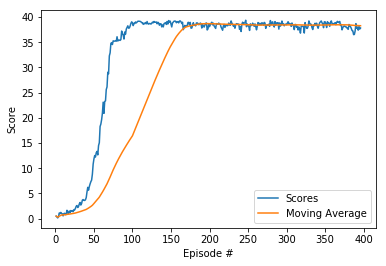

In [10]:
fig = plt.figure()
plt.subplot()
plt.plot(np.arange(1, len(scores)+1), scores, label='Scores')
plt.plot(np.arange(1, len(scores)+1), avgs, label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='lower right')
plt.show()

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, seed=123)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_reacher_20.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_reacher_20.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.550999138318005


In [12]:
env.close()

### Future Improvements

To further improve the agent in the future I would like to improve the agent by having it be asynchronus. This would allow for me to then parallelize training by having each instance be ran seperately. Currently the actions for all 20 instances are selected simultaneously. By being able to run multiple smaller networks at same time, this should make for faster training.